# Train an heuristic to play Go
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremynadal33/GameGo/blob/master/probaWinGo.ipynb)This notebook trains & compare DL models to predict a probability to win a game of GO from a given set of already played moves. 

The work in this notebook is based on [L. Simon's file](https://nbviewer.jupyter.org/urls/www.labri.fr/perso/lsimon/IA-M1/TP-Note-ML-GO.ipynb)

## First, let's import the database


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)

2.4.0


In [2]:
def get_raw_data_go(file):
    ''' Returns the set of samples from the local file or download it if it does not exists'''
    import gzip, os.path
    import json

    if not os.path.isfile(file):
        print("File", file, "not found, I am downloading it...\n", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/IA-M1/" + file, file)
        print(" Done")

    with gzip.open(file) as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

file = "samples-9x9.json.gz"
file_evaluate = "positions-to-evaluate-9x9.json.gz"
data = get_raw_data_go(file)
data_to_evaluate = get_raw_data_go(file_evaluate)

print("We have", len(data),"examples with the scores to train, ...")
print("We have", len(data_to_evaluate),"examples to score (but for which we don't know the real values)")

File samples-9x9.json.gz not found, I am downloading it...
 Done
File positions-to-evaluate-9x9.json.gz not found, I am downloading it...
 Done
We have 41563 examples with the scores to train, ...
We have 1000 examples to score (but for which we don't know the real values)


## Then, let's explore each entry
### First on the data set with results

In [3]:
def summary_of_example(data, sample_nb):
    ''' Gives you some insights about a sample number'''
    sample = data[sample_nb]
    print("Sample", sample_nb,'\n')
    print("Données brutes en format JSON:", sample, '\n')
    print("The sample was obtained after", sample["depth"], "moves")
    print("The successive moves were", sample["list_of_moves"])
    print("After these moves and all the captures, there was black stones at the following position", sample["black_stones"])
    print("After these moves and all the captures, there was white stones at the following position", sample["white_stones"])
    print("Number of rollouts (gnugo games played against itself from this position):", sample["rollouts"])
    print("Over these", sample["rollouts"], "games, black won", sample["black_wins"], "times with", sample["black_points"], "total points over all this winning games")
    print("Over these", sample["rollouts"], "games, white won", sample["white_wins"], "times with", sample["white_points"], "total points over all this winning games")

    
summary_of_example(data,10)

Sample 10 

Données brutes en format JSON: {'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0} 

The sample was obtained after 8 moves
The successive moves were ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7']
After these moves and all the captures, there was black stones at the following position ['B7', 'C6', 'E5', 'C3']
After these moves and all the captures, there was white stones at the following position ['C8', 'E7', 'H7', 'G3']
Number of rollouts (gnugo games played against itself from this position): 100
Over these 100 games, black won 60 times with 876.0 total points over all this winning games
Over these 100 games, white won 40 times with 378.0 total points over all this winning games


### On the data to evaluate, there is less information : 

In [4]:
print(data_to_evaluate[0])

{'depth': 16, 'list_of_moves': ['E6', 'E3', 'C3', 'G6', 'G7', 'C6', 'H7', 'H4', 'D2', 'F6', 'E8', 'C8', 'E5', 'B9', 'E7', 'E2'], 'black_stones': ['E8', 'E7', 'G7', 'H7', 'E6', 'E5', 'C3', 'D2'], 'white_stones': ['B9', 'C8', 'C6', 'F6', 'G6', 'H4', 'E3'], 'rollouts': 100}


## Let's try to get a deeper understanding of the data

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [6]:
df_data = pd.read_json(file)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41563 entries, 0 to 41562
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   depth          41563 non-null  int64 
 1   list_of_moves  41563 non-null  object
 2   black_stones   41563 non-null  object
 3   white_stones   41563 non-null  object
 4   rollouts       41563 non-null  int64 
 5   black_wins     41563 non-null  int64 
 6   black_points   41563 non-null  int64 
 7   white_wins     41563 non-null  int64 
 8   white_points   41563 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 2.9+ MB


In [7]:
df_data.describe()

,depth,rollouts,black_wins,black_points,white_wins,white_points
count,41563.000000,41563.0,41563.000000,41563.000000,41563.000000,41563.000000
mean,29.588047,100.0,64.926786,821.911147,35.063662,349.180497
std,15.448159,0.0,33.761025,734.782237,33.758351,507.659072
min,5.000000,100.0,0.000000,0.000000,0.000000,0.000000
25%,17.000000,100.0,47.000000,300.000000,1.000000,4.000000
50%,29.000000,100.0,71.000000,708.000000,29.000000,221.000000
75%,41.000000,100.0,99.000000,1103.000000,53.000000,471.500000
max,84.000000,100.0,100.000000,8100.000000,100.000000,8100.000000


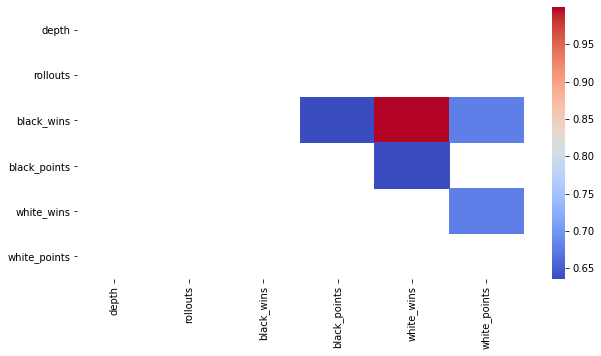

,Var 1,Var 2,correlation
0,black_wins,white_wins,0.999884
1,white_wins,white_points,0.679726
2,black_wins,white_points,0.679642
3,black_wins,black_points,0.635787
4,black_points,white_wins,0.635714


In [8]:
def corr_threshold(df,thresh, root_dir=''):
    import seaborn as sns
    upper = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(np.bool)).abs()
    upper = upper[upper>=thresh]
    
    plt.figure(figsize=(10,5))
    hm = sns.heatmap(upper, cmap="coolwarm")
    hm.set_xticklabels(hm.get_xticklabels(), rotation=90,fontsize=10)
    hm.set_yticklabels(hm.get_yticklabels(), rotation=0,fontsize=10) 

    plt.savefig(root_dir+'corr_heat.png',transparent=True)
    plt.show()
    
    upper = upper.stack().sort_values(ascending=False)
    upper = pd.DataFrame(upper).reset_index()
    upper.columns = ['Var 1', 'Var 2', 'correlation']
    
    index =  np.max([ i for i in range(len(upper['correlation'])) if upper['correlation'][i]>=thresh])
    return upper[:index+1]

corr_threshold(df_data, 0.5)

The CDF curve shows that black has more chances to win, globally


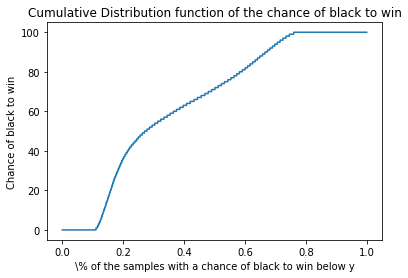

In [9]:
# Cumulative Distribution function of the chance of black to win
cdf_wins = sorted([sample["black_wins"] for sample in data])
plt.figure()
plt.plot([x/len(cdf_wins) for x in range(len(cdf_wins))], cdf_wins)
plt.title("Cumulative Distribution function of the chance of black to win")
plt.xlabel("\% of the samples with a chance of black to win below y")
plt.ylabel("Chance of black to win")
print("The CDF curve shows that black has more chances to win, globally")

plt.show()

In [10]:
df_data['range_game'] = 'Beginning'

df_data.loc[df_data['depth']>17,'range_game'] = 'Middle'
df_data.loc[df_data['depth']>41,'range_game'] = 'End'

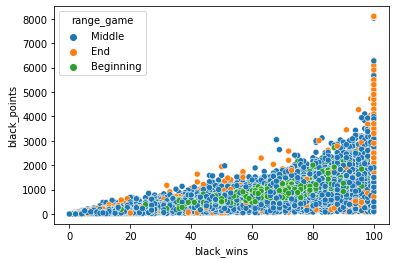

In [11]:
sns.scatterplot(x='black_wins', y='black_points', 
                hue='range_game', data=df_data ) 

In [12]:
df_data.groupby("range_game").describe().transpose()

range_game             Beginning           End        Middle
depth        count  11099.000000  10030.000000  20434.000000
             mean      11.002613     50.629312     29.354899
             std        3.735088      7.169986      6.899394
             min        5.000000     42.000000     18.000000
             25%        8.000000     45.000000     23.000000
             50%       11.000000     49.000000     29.000000
             75%       14.000000     55.000000     35.000000
             max       17.000000     84.000000     41.000000
rollouts     count  11099.000000  10030.000000  20434.000000
             mean     100.000000    100.000000    100.000000
             std        0.000000      0.000000      0.000000
             min      100.000000    100.000000    100.000000
             25%      100.000000    100.000000    100.000000
             50%      100.000000    100.000000    100.000000
             75%      100.000000    100.000000    100.000000
             max      100.000000    100.000000    100.000000
black_wins   count  11099.000000  10030.000000  20434.000000
             mean      63.841337     63.621037     66.157287
             std       14.649376     46.307928     33.857831
             min        1.000000      0.000000      0.000000
             25%       55.000000      0.000000     43.000000
             50%       64.000000    100.000000     77.000000
             75%       74.000000    100.000000     98.000000
             max      100.000000    100.000000    100.000000
black_points count  11099.000000  10030.000000  20434.000000
             mean     840.501036    855.098903    795.523637
             std      323.330599   1084.402552    680.309157
             min        1.000000      0.000000      0.000000
             25%      626.000000      0.000000    273.000000
             50%      817.000000    500.000000    676.000000
             75%     1030.000000   1300.000000   1142.000000
             max     2723.000000   8100.000000   8100.000000
white_wins   count  11099.000000  10030.000000  20434.000000
             mean      36.151185     36.361715     33.835813
             std       14.648615     46.302647     33.856336
             min        0.000000      0.000000      0.000000
             25%       26.000000      0.000000      2.000000
             50%       36.000000      0.000000     23.000000
             75%       45.000000    100.000000     57.000000
             max       99.000000    100.000000    100.000000
white_points count  11099.000000  10030.000000  20434.000000
             mean     372.590954    397.265803    312.862190
             std      195.616736    802.707431    429.443238
             min        0.000000      0.000000      0.000000
             25%      234.000000      0.000000     11.000000
             50%      351.000000      0.000000    158.000000
             75%      480.000000    500.000000    446.000000
             max     2055.000000   8100.000000   8100.000000

## Information from the dataset of train :
* There is 41563 games 
* There is almost 65 % of games won by the player black -> hidden bias ? 
* A given board is awarded a certain number of points as well as the winning porbability
* The score of the board and the probability of winning are highly correlated
* The depth of the game seems important to predict the probability of winning

## Let's transform the input data into numpy arrays to feed the NN

In [13]:
import numpy as np

def name_to_coord(s):
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}

    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin

 # Vous pouvez utiliser votre propre fonction ici si vous voulez utiliser un autre encodage
def json_to_numpy(sample):
    to_return = np.zeros((9,9,2))
    indices = ["black_stones", "white_stones"]
    for plane, name in enumerate(indices):
        for coord_name in sample[name]:
            x, y = name_to_coord(coord_name)
            to_return[x,y,plane] = 1
    return to_return


In [14]:
samp = 10
print('For sample ', samp)
print(data[samp])
encoded = json_to_numpy(data[samp])

print("_________________________\nEncoded shape is")
print(encoded.shape)
print("The first dimension contains the positioning of the black pieces")
print(encoded[:,:,0])
print("Black pieces with positions: ", data[10]["black_stones"],'\n')
print("The second dimension contains the positioning of the white pieces")
print(encoded[:,:,1])
print("White pieces with positions ", data[10]["white_stones"])

For sample  10
{'depth': 8, 'list_of_moves': ['C6', 'E7', 'C3', 'C8', 'E5', 'G3', 'B7', 'H7'], 'black_stones': ['B7', 'C6', 'E5', 'C3'], 'white_stones': ['C8', 'E7', 'H7', 'G3'], 'rollouts': 100, 'black_wins': 60, 'black_points': 876.0, 'white_wins': 40, 'white_points': 378.0}
_________________________
Encoded shape is
(9, 9, 2)
The first dimension contains the positioning of the black pieces
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Black pieces with positions:  ['B7', 'C6', 'E5', 'C3'] 

The second dimension contains the positioning of the white pieces
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]


## We will train a model that predicts the probability of winning 
To make things easier, we will build a pipeline that processes the json entry, modify it into a numpy array and predicts ***the probability of chance for the black player to win***. 

To begin with, let's implement a convolutional based NN that process ***only the two sets of boards*** as a whole information.

In [16]:
def get_dataset(data, random_state = 42, test_size = 0.33) : 
  X = []
  y = []
  for d in data:
    X.append(json_to_numpy(d))
    y.append(d["black_wins"] / d["rollouts"])


  for i in range(len(data)):
    rot1 = np.rot90(X[i], k = 1)
    rot2 = np.rot90(X[i], k = 2)
    rot3 = np.rot90(X[i], k = 3)
    symver = np.flipud(X[i])
    symhor = np.fliplr(X[i])

    X.append(rot1)
    X.append(rot2)
    X.append(rot3)
    X.append(symver)
    X.append(symhor)


    y.append(y[i])
    y.append(y[i])
    y.append(y[i])
    y.append(y[i])
    y.append(y[i])


  X = np.array(X)
  y = np.array(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state= random_state)
  print('Each entry is of shape : {}\nThere is {} samples in the train set and {} in the test'.format( X_train[0].shape, X_train.shape[0], X_test.shape[0] ))
  print('Here is a sample : \nX[0] :',X_train[0][0] , '\nX[1] :', X_train[0][1] , '\n y :',y_train[0])
  return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test = get_dataset(data, test_size = 0.1)

Each entry is of shape : (9, 9, 2)
There is 224440 samples in the train set and 24938 in the test
Here is a sample : 
X[0] : [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]] 
X[1] : [[0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]] 
 y : 0.44


In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(9,9,2)))
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(50,activation='relu'))
model.add(tf.keras.layers.Dense(35,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 9, 32)          608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                129650    
_________________________________________________________________
dense_1 (Dense)              (None, 35)                1785      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 36        
Total params: 141,327
Trainable params: 141,327
Non-trainable params: 0
__________________________________________________

In [20]:
model.compile(optimizer='adam',loss=tf.keras.losses.MeanAbsoluteError())

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 20, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 

                    callbacks = callbacks, 
                    epochs=100)

Epoch 1/100
7014/7014 [==============================] - 24s 2ms/step - loss: 0.1695 - val_loss: 0.1193
Epoch 2/100
7014/7014 [==============================] - 17s 2ms/step - loss: 0.1154 - val_loss: 0.1066
Epoch 3/100
7014/7014 [==============================] - 17s 2ms/step - loss: 0.1067 - val_loss: 0.1000
Epoch 4/100
7014/7014 [==============================] - 16s 2ms/step - loss: 0.1021 - val_loss: 0.1032
Epoch 5/100
7014/7014 [==============================] - 16s 2ms/step - loss: 0.0991 - val_loss: 0.1007
Epoch 6/100
7014/7014 [==============================] - 17s 2ms/step - loss: 0.0969 - val_loss: 0.0984
Epoch 7/100
7014/7014 [==============================] - 17s 2ms/step - loss: 0.0953 - val_loss: 0.1078
Epoch 8/100
7014/7014 [==============================] - 17s 2ms/step - loss: 0.0934 - val_loss: 0.0958
Epoch 9/100
7014/7014 [==============================] - 17s 2ms/step - loss: 0.0914 - val_loss: 0.0976
Epoch 10/100
7014/7014 [==============================] - 17s 2m

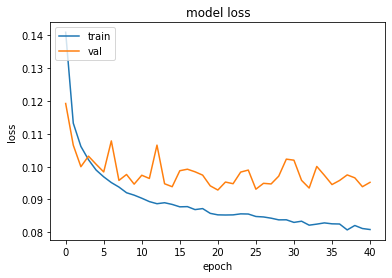

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
print('Mean absolute error on test set : ', mean_absolute_error(y_test, y_pred))

Mean absolute error on test set :  0.0928799890447434
